# apply instruments settings

In [295]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [568]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()
# mwsyn.close()
# laser.close()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [569]:
current_percent = 90.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [534]:
# laserpower = 145.0
# laser.laser_off()
# laser.set_analog_control_mode("power")
# laser.set_modulation_state("CW")
# laser.set_laser_power(laserpower, save_memory=False)
# laser.laser_on()

In [570]:
f_NVguess = 398.5607725381851
f_NVguess = 398.5547716319561
# f_NVguess = 392.83677300810814
f_NVguess = 392.8397714495659
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.36832381039858 GHz
Actual Output CW Freqeuncy :16.36832381039858 GHz


In [587]:
NI_ratebase = 100.00/1E3 # GHz
NI_timebase = 1.0/NI_ratebase #ns
laser_init = 1000
wait_init = 600
mw_dur_start = 0.0
mw_dur_stop = 6400
mw_dur_step = 32
mw_dur = np.arange(mw_dur_start, mw_dur_stop+mw_dur_step, mw_dur_step)
# mw_dur = np.geomspace(mw_dur_start, mw_dur_stop, 320, endpoint=True)
# rounding is IMPORTANT!!
# mw_dur = np.round(NI_ratebase*mw_dur)*NI_timebase # round to DAQ timebase
mw_dur = np.round(mw_dur) # round to PS timebase
mw_dur_stop = mw_dur[-1]
mw_dur_start = mw_dur[0]
wait_read = 800
laser_read = 800

# here is to fix the timing
totaltime_max = laser_init+wait_init+mw_dur_stop+wait_read+laser_read
tbmultiple = int(NI_ratebase*totaltime_max+1)
sampling_rate = NI_ratebase/tbmultiple
sampletime = round(1.0/sampling_rate)
samplerate = 1.0/sampletime #GHz
padding_fix = sampletime-totaltime_max
padding = padding_fix+mw_dur_stop-mw_dur # depends on MW duration
num_pt = len(mw_dur)

assert np.all(padding+mw_dur+laser_init+wait_init+wait_read+laser_read == sampletime)
assert padding_fix >= 0


In [588]:
# readoffset = NI_timebase*30
delaydiff = NI_timebase*15.0
readoffset = NI_timebase*25.0
# delaydiff = NI_timebase*0.0
# readoffset = laser_read - 20
daqpadding = sampletime - (laser_read - readoffset - delaydiff)
daqpadding = int(NI_ratebase*daqpadding)/NI_ratebase
# daqdelay = NI_timebase*20.0
daqdelay = 0.0
daqtriggerdelay = NI_timebase*0.0
# daqpadding = 1.0/clock_rate*1.0
# daqpadding = int(clock_rate*(1.0/sampling_rate-(laser_read-250.0)))/clock_rate
# daqpadding = 0.0


seq_daqtrig = [(daqdelay, LOW)] + [(daqtriggerdelay, LOW)] + [(daqpadding-NI_ratebase*10, LOW)] + [(sampletime, HIGH), (sampletime*(num_pt*2 - 1) - daqtriggerdelay-daqpadding+NI_ratebase*10, LOW)]
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple+int(daqpadding*clock_rate))
# seq_clock = [(daqpadding, LOW)] + [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple)
seq_clock = [(daqdelay, LOW)] + [(daqpadding, LOW),(sampletime-daqpadding, HIGH)]*num_pt*2
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]

seq_laser = []
seq_mwA = []
seq_mwB = []
skip = 0
seq_laser_sub_alloff = [(padding[-1], LOW), (laser_init, LOW), (wait_init, LOW), (mw_dur[-1], LOW), (wait_read, LOW), (laser_read, LOW)]
# for mwd, pd in zip(mw_dur, padding):
for ii in range(len(mw_dur)-skip):
    mwd = mw_dur[ii]
    pd = padding[ii]
    seq_laser_sub = [(pd, LOW), (laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH)]
    seq_mwA_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_noMW_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW)]
    # seq_laser_sub = [(laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH), (pd, LOW)]
    # seq_mwA_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    # seq_mwA_noMW_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    seq_laser += seq_laser_sub + seq_laser_sub
    # seq_laser += seq_laser_sub + seq_laser_sub_alloff
    seq_mwA += seq_mwA_sub + seq_mwA_noMW_sub
    seq_mwB += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
    # seq_mwA += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
seq_laser += (seq_laser_sub_alloff + seq_laser_sub_alloff)*skip
seq_mwA += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_mwB += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_laser +=  [(daqdelay, LOW)]
seq_mwA +=  [(daqdelay, LOW)]
seq_mwB +=  [(daqdelay, LOW)]
# seq_laser = [(daqtrigdelay,LOW)] + seq_laser
# seq_laser = [(0.5/clock_rate, HIGH),(0.5/clock_rate, HIGH)]*(num_pt*2*clockmultiple+int(daqtrigdelay*clock_rate))
# seq_mwA = [(daqtrigdelay,LOW)] + seq_mwA
# seq_laser += [(daqpadding, LOW)]
# seq_mwA += [(daqpadding, LOW)]

rrr = 8
pg.setDigital("laser", seq_laser*rrr)
pg.setDigital("mw_A", seq_mwA*rrr)
pg.setDigital("mw_B", seq_mwB*rrr)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("daqtrig", seq_daqtrig*rrr)
pg.setDigital("clock", seq_clock*rrr)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
assert round(np.sum(np.array(seq_laser)[:, 0])) == round(np.sum(np.array(seq_mwA)[:, 0])) == round(np.sum(np.array(seq_daqtrig)[:, 0])) == round(np.sum(np.array(seq_clock)[:, 0]))
assert sampletime > daqpadding + 10

In [589]:
aa = np.sum(np.array(seq_laser)[:, 0])
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_mwA)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_daqtrig)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_clock)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")

Total Seq. Time: 3863220.0ns
Total Seq. Time: 3863220.0ns
Total Seq. Time: 3863220.0ns
Total Seq. Time: 3863220.0ns


In [591]:
# signal reading parameters
min_volt = -0.005 # [V]
max_volt = 0.05
samplerate_read = samplerate*1E9 # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readsample = num_pt*2
timeout_read = max(num_readsample/samplerate_read, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hdc.NI_ch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hdc.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS, 
    # sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hdc.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [590]:
readtask.close()

# Start measurement


In [592]:
laser.laser_on() # turn on laser

In [593]:
pg.stream(n_runs=INF)
pg.startNow()
# signal = np.zeros(num_pt)
# background = np.zeros(num_pt)
# repeat measurement

signal_av = np.zeros(num_pt, dtype=np.float64, order='C')
background_av = np.zeros(num_pt, dtype=np.float64, order='C')
readtask.start() # ready to read data
read_duration = 16  # read data for 5 seconds
start_time = time.time()
num_repeat = 0
while time.time() - start_time < read_duration:
# for kkk in range(num_repeat):
    # readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            num_readsample,
            timeout_read
        )
    # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    signal_av += np.copy(buffer_readpoint[0::2])
    background_av += np.copy(buffer_readpoint[1::2])
    # readtask.stop()
    num_repeat += 1
readtask.stop()
# laser.laser_off()
# readtask.close()
signal_av = signal_av/num_repeat
background_av = background_av/num_repeat
contrast = (signal_av-background_av)/background_av
print(f"measurement repeat : {num_repeat} times")

measurement repeat : 4136 times


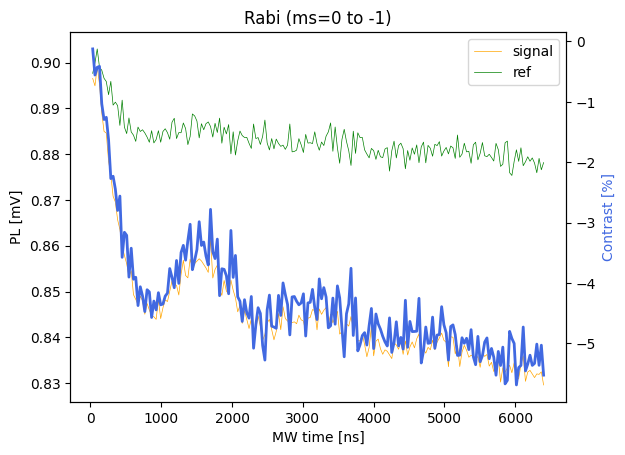

In [594]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 50
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

In [595]:
np.savetxt('output\\20240506_eveningmeasurementdebug\\m1rabi_fristoscillation.txt', np.c_[mw_dur, signal_av, background_av])

In [566]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
# mwsyn.reboot()

In [28]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [567]:
# close the communication
laser.close()
mwsyn.close()
pg.reset()